### Описание задачи

Входные данные - [биржевой стакан](https://en.wikipedia.org/wiki/Order_book_(trading)) некоторого актива. Он содержит в себе ценовые уровни и объемы заявок на уровне. Глубина стакана - 5.  
В данных приведён стакан на каждый тик биржи.  
ask_rate - цены заявок на продажу  
ask_amount - объёмы заявок на продажу  
bid_rate - цены заявок на покупку  
bid_amount - объёмы заявок на покупку

На каждый тик определим цену актива. Возьмём среднее между наименьшим ask_rate (askbest) и наибольшим bid_rate (bidbest) в момент времени t:  
$$ midprice(t) = (askbest(t) + bidbest(t)) / 2 $$  

Определим целевую переменную. Будем прогнозировать изменение midprice через четыре тика (в момент времени t + 4):
$$ target(t) = midprice(t + 4) - midprice(t) $$ 

**Цель тестового задания - решить задачу регрессии.**  

Данные находятся в двух файлах.  
train.csv - данные для обучения и валидации модели  
test.csv - данные для финальной оценки качества модели  

#### Идеи для признаков:
- суммарный объем заявок в стакане
- дисбаланс объемов всех заявок на продажу и всех заявок на покупку
- разница между лучшей ценой на продажу и лучшей ценой на покупку  
- волатильность цены за период  
- цена n тиков назад

#### Критерии оценки: 
- структура построения пайплайна обучения модели    
- качество кода  
- точность прогноза по метрике RMSE на данных из test.csv 

In [1]:
import os
import datetime

import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.linear_model import HuberRegressor

from scipy import stats

import fbprophet

tf.random.set_seed(2)
os.environ['CUDA_VISIBLE_DEVICES'] = '6'

Importing plotly failed. Interactive plots will not work.


# Считывание данных

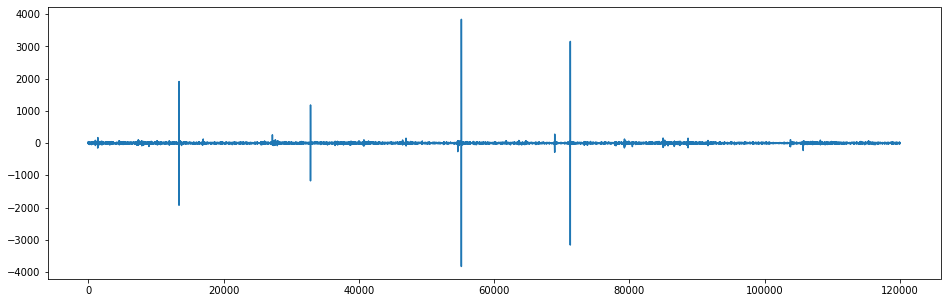

In [2]:
df = pd.read_pickle('train.pkl')
test = pd.read_pickle('test.pkl')

df['target'].plot(figsize=(16,5))

# Автоматическое детектирование аномалий и редактирование их значений

In [3]:
def fit_predict_model(dataframe, interval_width = 0.99, changepoint_range = 0.8):
    m = fbprophet.Prophet(daily_seasonality = False, yearly_seasonality = False, weekly_seasonality = False,
                seasonality_mode = 'multiplicative', 
                interval_width = interval_width,
                changepoint_range = changepoint_range)
    m = m.fit(dataframe)
    forecast = m.predict(dataframe)
    forecast['fact'] = dataframe['y'].reset_index(drop = True)
    return forecast

base = datetime.datetime.today()
date_list = [base + datetime.timedelta(minutes=x) for x in range(len(df['target']))]

df2 = pd.DataFrame(np.array([date_list, df['target'] + 1]).transpose(), columns=['ds', 'y'])
anomaly_model_pred = fit_predict_model(df2)

In [4]:
def detect_anomalies(forecast):
    forecasted = forecast[['ds','trend', 'yhat', 'yhat_lower', 'yhat_upper', 'fact']].copy()

    forecasted['anomaly'] = 0
    forecasted.loc[forecasted['fact'] > forecasted['yhat_upper'], 'anomaly'] = 1
    forecasted.loc[forecasted['fact'] < forecasted['yhat_lower'], 'anomaly'] = -1

    #anomaly importances
    forecasted['importance'] = 0
    forecasted.loc[forecasted['anomaly'] ==1, 'importance'] = \
        (forecasted['fact'] - forecasted['yhat_upper'])/forecast['fact']
    forecasted.loc[forecasted['anomaly'] ==-1, 'importance'] = \
        (forecasted['yhat_lower'] - forecasted['fact'])/forecast['fact']
    
    return forecasted

anomaly_pred = detect_anomalies(anomaly_model_pred)

In [5]:
importance_anomaly = anomaly_pred[(anomaly_pred['anomaly'] != 0) & 
                                  (abs(anomaly_pred['importance']) > 0.0)] # находим все аномалии с importance > 0.9

mode_target = stats.mode(df['target'])[0][0] # Находим моду, чтобы заменить аномальные значения в target

for _, row in importance_anomaly.iterrows():
    
    df.loc[row.name, 'target'] = mode_target
    df.loc[row.name + 4, 'midprice'] = df.iloc[row.name]['midprice'] + mode_target

# Проверка ряда на стационарность

### Проверка target

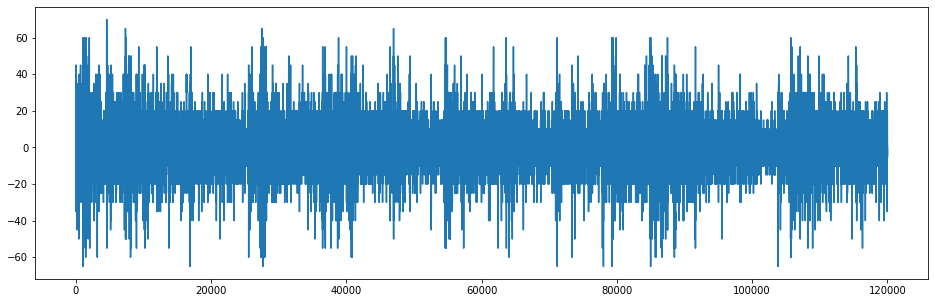

In [6]:
df['target'].plot(figsize=(16,5))

### Проверка midprice

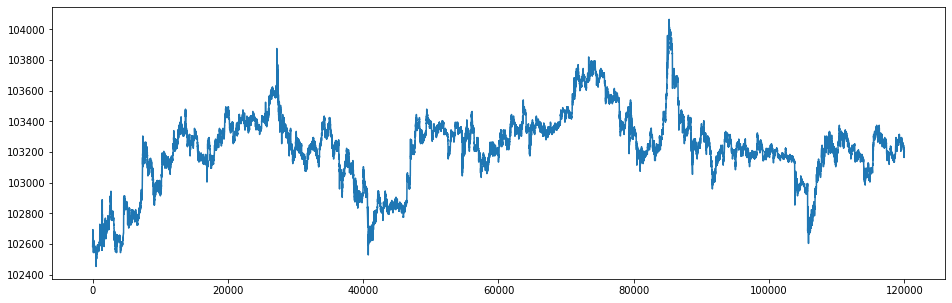

In [7]:
df['midprice'].plot(figsize=(16,5))

##### Проверка Mean

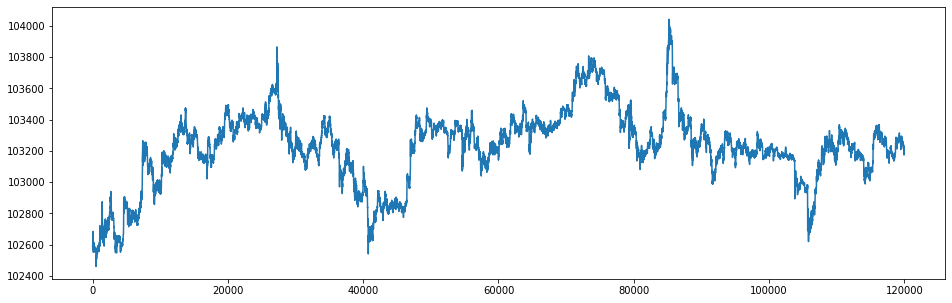

In [8]:
df['midprice'].rolling(4).mean().plot(figsize=(16,5))

##### Проверка std

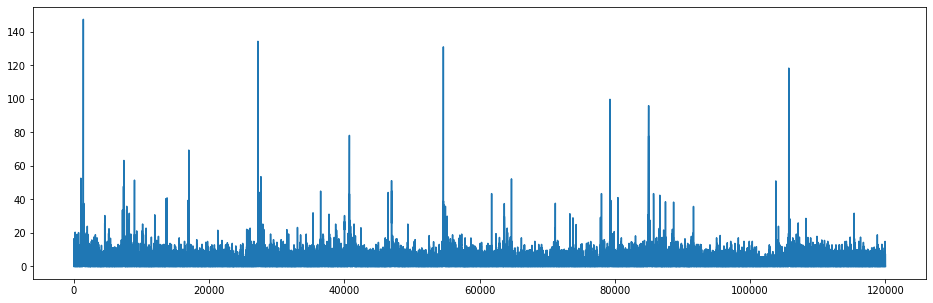

In [9]:
df['midprice'].rolling(4).std().plot(figsize=(16,5))

##### Тест Дики-Фуллера

In [10]:
dftest = adfuller(df['midprice'], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Test Statistic                     -3.787857
p-value                             0.003034
#Lags Used                         64.000000
Number of Observations Used    119935.000000
Critical Value (1%)                -3.430405
Critical Value (5%)                -2.861564
Critical Value (10%)               -2.566783
dtype: float64


# Обучение

## SARIMAX (плохой результат)

#### Автокорреляция и частичная автокорреляция

По данным графикам происходит подбор параметров Q и q, P и p для модели SARIMA.

Q - последний значимый СЕЗОНННЫЙ лаг.  
q - последний значимый НЕСЕЗОННЫЙ лаг.  
P - последний значимый СЕЗОННЫЙ лаг при частичный автокорреляции.  
p - последний значимый НЕСЕЗОННЫЙ лаг при частичный автокорреляции.  

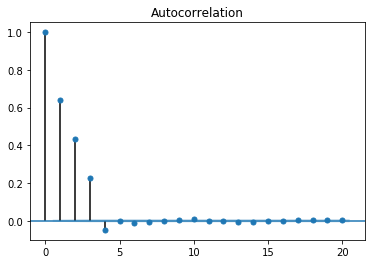

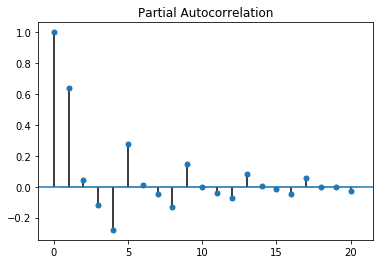

In [11]:
plot_acf(df['target'], lags=20)
plt.show()

plot_pacf(df['target'], lags=20)
plt.show()

In [12]:
my_order = (3, 0, 3)
my_seasonal_order = (4, 0, 4, 4)

mod = SARIMAX(df['target'], order=my_order, seasonal_order=my_seasonal_order)
res = mod.fit(disp=True)
print(res.summary())

                                          SARIMAX Results                                           
Dep. Variable:                                       target   No. Observations:               120000
Model:             SARIMAX(3, 0, 3)x(4, 0, [1, 2, 3, 4], 4)   Log Likelihood             -393503.589
Date:                                      Mon, 17 Aug 2020   AIC                         787037.178
Time:                                              10:22:47   BIC                         787182.607
Sample:                                                   0   HQIC                        787080.954
                                                   - 120000                                         
Covariance Type:                                        opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1912      0.002  

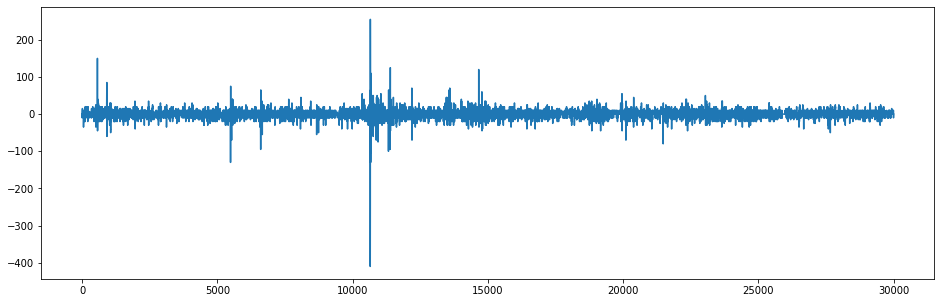

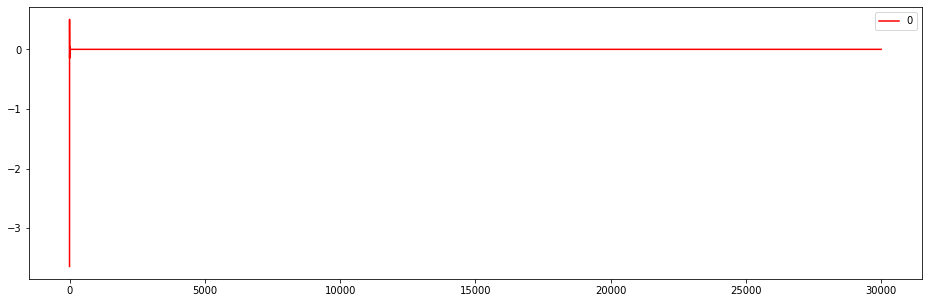

In [13]:
predict = res.forecast(30000)

test['target'].plot(figsize=(16,5))
pd.DataFrame(predict.to_numpy()).plot(figsize=(16,5), color='red')

## HuberRegressor (для midprice)

#### Цена за период

In [14]:
shift_value = 8

tr_period = pd.concat([df['midprice'].shift(i) for i in range(shift_value,0,-1)], axis=1).dropna().to_numpy()
te_period = pd.concat([test['midprice'].shift(i) for i in range(shift_value,0,-1)], axis=1).dropna().to_numpy()

#### Cуммарный объем заявок в стакане

In [15]:
tr_total_orders = (np.sum(df['ask_amount'].to_list(), axis=1) + np.sum(df['bid_amount'].to_list(), axis=1))[shift_value:]
te_total_orders = (np.sum(test['ask_amount'].to_list(), axis=1) + np.sum(test['bid_amount'].to_list(), axis=1))[shift_value:]

#### Дисбаланс объемов всех заявок на продажу и всех заявок на покупку (разность между суммарным объемом заявок на продажу и суммарным обьемом заявок на покупку)

In [16]:
tr_imbalance = (np.sum(df['ask_amount'].to_list(), axis=1) - np.sum(df['bid_amount'].to_list(), axis=1))[shift_value:]
te_imbalance = (np.sum(test['ask_amount'].to_list(), axis=1) - np.sum(test['bid_amount'].to_list(), axis=1))[shift_value:]

#### Разница между лучшей ценой на продажу и лучшей ценой на покупку

In [17]:
tr_min_diff = (np.min(df['ask_rate'].to_list(), axis=1) - np.max(df['bid_rate'].to_list(), axis=1))[shift_value:]
te_min_diff = (np.min(test['ask_rate'].to_list(), axis=1) - np.max(test['bid_rate'].to_list(), axis=1))[shift_value:]

#### Средняя цена

In [18]:
tr_mid_price = (df['midprice'].to_numpy())[shift_value:]
te_mid_price = (test['midprice'].to_numpy())[shift_value:]

#### Общий вектор признаков (изменить флаг, чтобы использовать midprice (MP) или target

In [19]:
MP_FLAG = True

X_train = np.vstack([tr_period[:, i] for i in range(shift_value)])
X_train = np.vstack([X_train, tr_total_orders, tr_imbalance, tr_min_diff, tr_mid_price]).transpose()

X_test = np.vstack([te_period[:, i] for i in range(shift_value)])
X_test = np.vstack([X_test, te_total_orders, te_imbalance, te_min_diff, te_mid_price]).transpose()

if MP_FLAG:
    y_train = (df['midprice'] + df['target']).to_numpy()[shift_value:]
    y_test = (test['midprice'] + test['target']).to_numpy()[shift_value:]
    
else:
    X_train_min = X_train.min(axis=0)
    X_train_max = X_train.max(axis=0)
    X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_test = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    y_train = df['target'].to_numpy()[shift_value:]
    y_test = test['target'].to_numpy()[shift_value:]

    y_train_min = y_train.min(axis=0)
    y_train_max = y_train.max(axis=0)
    y_train = (y_train - y_train_min) / (y_train_max - y_train_min)
    y_test = (y_test - y_train_min) / (y_train_max - y_train_min)    

#### Обучение модели

In [20]:
model = HuberRegressor(epsilon=1.35, max_iter=120000, alpha=0.01)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))

y_pred_df = pd.DataFrame(data=y_pred)
y_test_df = pd.DataFrame(data=y_test)

110.20381321468281


#### Проверка модели на несмещенность

0    0.057672
dtype: float64
WilcoxonResult(statistic=219063068.0, pvalue=0.0001025742200770588)


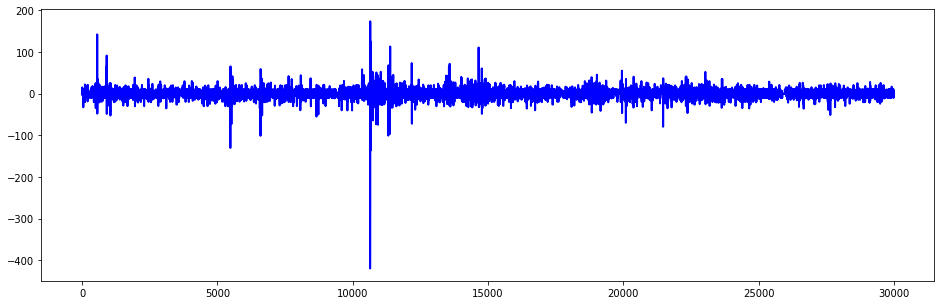

In [21]:
plt.figure(figsize=(16,5))
plt.plot(y_test_df - y_pred_df, marker='', color='blue', linewidth=2)

print(np.mean(y_test_df - y_pred_df))
print(stats.wilcoxon((y_test_df - y_pred_df).to_numpy().flatten()))

#### Построение модели для тестовых данных

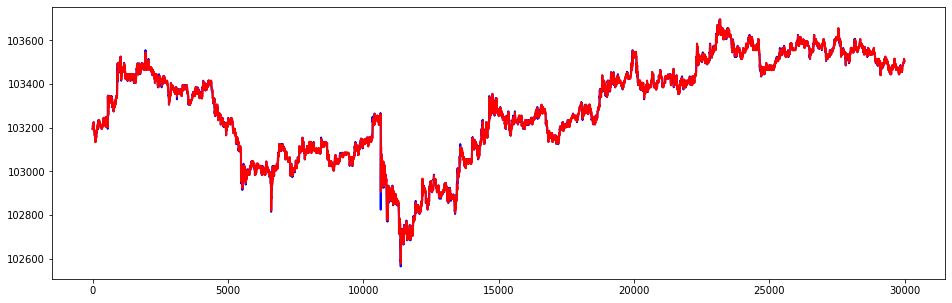

In [22]:
plt.figure(figsize=(16,5))
plt.plot(y_test_df, marker='', color='blue', linewidth=2)
plt.plot(y_pred_df, marker='', color='red', linewidth=2)

#### Построение гистограммы распределения ошибок

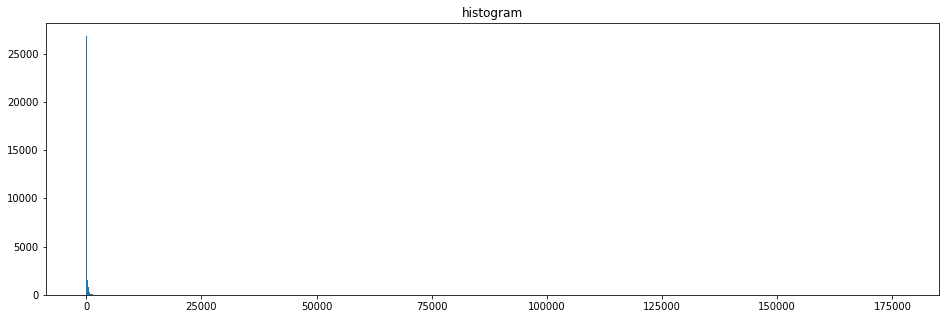

In [23]:
plt.figure(figsize=(16,5))
plt.hist(np.square(y_test - y_pred), bins=1000) 
plt.title("histogram") 
plt.show()

## Реккурентная нейронная сеть

#### Cуммарный объем заявок в стакане

In [24]:
tr_total_orders = (np.sum(df['ask_amount'].to_list(), axis=1) + np.sum(df['bid_amount'].to_list(), axis=1))
te_total_orders = (np.sum(test['ask_amount'].to_list(), axis=1) + np.sum(test['bid_amount'].to_list(), axis=1))

#### Дисбаланс объемов всех заявок на продажу и всех заявок на покупку (разность между суммарным объемом заявок на продажу и суммарным обьемом заявок на покупку)

In [25]:
tr_imbalance = (np.sum(df['ask_amount'].to_list(), axis=1) - np.sum(df['bid_amount'].to_list(), axis=1))
te_imbalance = (np.sum(test['ask_amount'].to_list(), axis=1) - np.sum(test['bid_amount'].to_list(), axis=1))

#### Разница между лучшей ценой на продажу и лучшей ценой на покупку

In [26]:
tr_min_diff = (np.min(df['ask_rate'].to_list(), axis=1) - np.max(df['bid_rate'].to_list(), axis=1))
te_min_diff = (np.min(test['ask_rate'].to_list(), axis=1) - np.max(test['bid_rate'].to_list(), axis=1))

#### Средняя цена

In [27]:
tr_mid_price = (df['midprice'].to_numpy())
te_mid_price = (test['midprice'].to_numpy())

#### Объединение предыдущих признаков в единую матрицу признаков

In [28]:
X_train = np.vstack([tr_total_orders, tr_imbalance, tr_min_diff, tr_mid_price]).transpose()
X_test = np.vstack([te_total_orders, te_imbalance, te_min_diff, te_mid_price]).transpose()

X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std


y_train = (df['midprice'] + df['target']).to_numpy()
y_test = (test['midprice'] + test['target']).to_numpy()

y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

In [29]:
def multivariate_data(dataset, target, history_size, target_size):
    data = []
    labels = []

    start_index = history_size
    end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, 1)
        data.append(dataset[indices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

#### Формирование обучающей выборки для реккурентной нейронной сети с историей из 16 тиков. Предсказываем событие через 4 тика.

In [30]:
past_history = 16
future_target = 4

x_train_single, y_train_single = multivariate_data(X_train, y_train,
                                                   past_history,
                                                   future_target)

x_test_single, y_test_single = multivariate_data(X_test, y_test,
                                                 past_history,
                                                 future_target)

In [31]:
BATCH_SIZE = 256
BUFFER_SIZE = 200

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

In [32]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [33]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=test_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.2294 - val_loss: 0.0318
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0136 - val_loss: 0.0455
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0181 - val_loss: 0.0152
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0059 - val_loss: 0.0116
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0098 - val_loss: 0.0099
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0051 - val_loss: 0.0116
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0058 - val_loss: 0.0086
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0067 - val_loss: 0.0070
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0046 - val_loss: 0.0110
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 0.0058 - val_loss: 0.0077

In [34]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


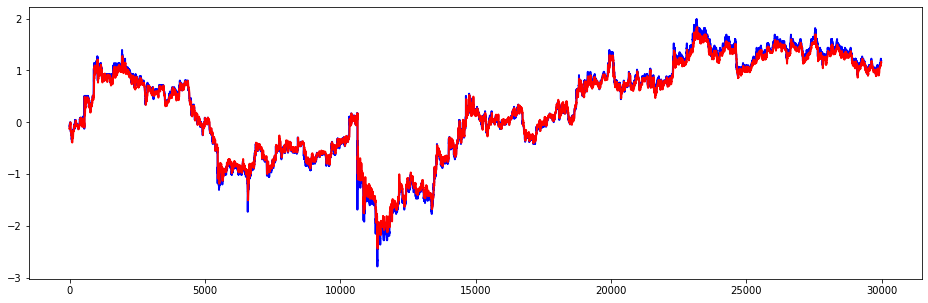

In [35]:
y_pred = single_step_model.predict(x_test_single).flatten()

y_pred_df = pd.DataFrame(data=y_pred)
y_test_df = pd.DataFrame(data=y_test_single)

plt.figure(figsize=(16,5))
plt.plot(y_test_df, marker='', color='blue', linewidth=2)
plt.plot(y_pred_df, marker='', color='red', linewidth=2)

## HuberRegressor (для target)

#### Цена за период

In [36]:
shift_value = 8

tr_period = pd.concat([df['midprice'].shift(i) for i in range(shift_value,0,-1)], axis=1).dropna().to_numpy()
te_period = pd.concat([test['midprice'].shift(i) for i in range(shift_value,0,-1)], axis=1).dropna().to_numpy()

#### Cуммарный объем заявок в стакане

In [37]:
tr_total_orders = (np.sum(df['ask_amount'].to_list(), axis=1) + np.sum(df['bid_amount'].to_list(), axis=1))[shift_value:]
te_total_orders = (np.sum(test['ask_amount'].to_list(), axis=1) + np.sum(test['bid_amount'].to_list(), axis=1))[shift_value:]

#### Дисбаланс объемов всех заявок на продажу и всех заявок на покупку (разность между суммарным объемом заявок на продажу и суммарным обьемом заявок на покупку)

In [38]:
tr_imbalance = (np.sum(df['ask_amount'].to_list(), axis=1) - np.sum(df['bid_amount'].to_list(), axis=1))[shift_value:]
te_imbalance = (np.sum(test['ask_amount'].to_list(), axis=1) - np.sum(test['bid_amount'].to_list(), axis=1))[shift_value:]

#### Разница между лучшей ценой на продажу и лучшей ценой на покупку

In [39]:
tr_min_diff = (np.min(df['ask_rate'].to_list(), axis=1) - np.max(df['bid_rate'].to_list(), axis=1))[shift_value:]
te_min_diff = (np.min(test['ask_rate'].to_list(), axis=1) - np.max(test['bid_rate'].to_list(), axis=1))[shift_value:]

#### Средняя цена

In [40]:
tr_mid_price = (df['midprice'].to_numpy())[shift_value:]
te_mid_price = (test['midprice'].to_numpy())[shift_value:]

#### Общий вектор признаков (изменить флаг, чтобы использовать midprice (MP) или target

In [41]:
MP_FLAG = False

X_train = np.vstack([tr_period[:, i] for i in range(shift_value)])
X_train = np.vstack([X_train, tr_total_orders, tr_imbalance, tr_min_diff, tr_mid_price]).transpose()

X_test = np.vstack([te_period[:, i] for i in range(shift_value)])
X_test = np.vstack([X_test, te_total_orders, te_imbalance, te_min_diff, te_mid_price]).transpose()

if MP_FLAG:
    y_train = (df['midprice'] + df['target']).to_numpy()[shift_value:]
    y_test = (test['midprice'] + test['target']).to_numpy()[shift_value:]
    
else:
    X_train_min = X_train.min(axis=0)
    X_train_max = X_train.max(axis=0)
    X_train = (X_train - X_train_min) / (X_train_max - X_train_min)
    X_test = (X_test - X_train_min) / (X_train_max - X_train_min)
    
    y_train = df['target'].to_numpy()[shift_value:]
    y_test = test['target'].to_numpy()[shift_value:]

    y_train_min = y_train.min(axis=0)
    y_train_max = y_train.max(axis=0)
    y_train = (y_train - y_train_min) / (y_train_max - y_train_min)
    y_test = (y_test - y_train_min) / (y_train_max - y_train_min)    

#### Обучение модели

In [42]:
model = HuberRegressor(epsilon=1.35, max_iter=120000, alpha=0.01)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(mean_squared_error(y_test, y_pred))

y_pred_df = pd.DataFrame(data=y_pred)
y_test_df = pd.DataFrame(data=y_test)

0.005942974416120551


#### Проверка модели на несмещенность

0    0.000934
dtype: float64
WilcoxonResult(statistic=213545329.0, pvalue=3.899795125494747e-14)


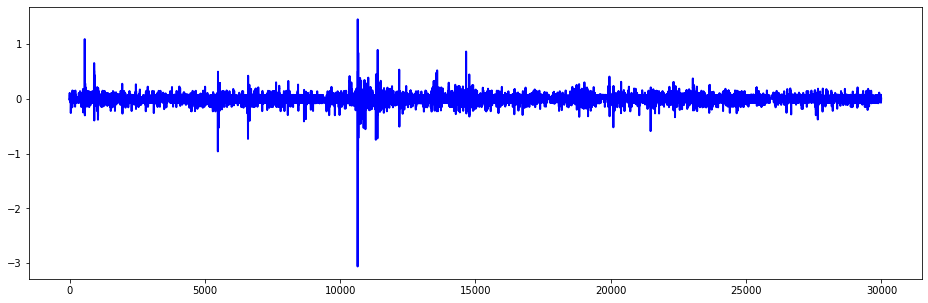

In [43]:
plt.figure(figsize=(16,5))
plt.plot(y_test_df - y_pred_df, marker='', color='blue', linewidth=2)

print(np.mean(y_test_df - y_pred_df))
print(stats.wilcoxon((y_test_df - y_pred_df).to_numpy().flatten()))

#### Построение модели для тестовых данных

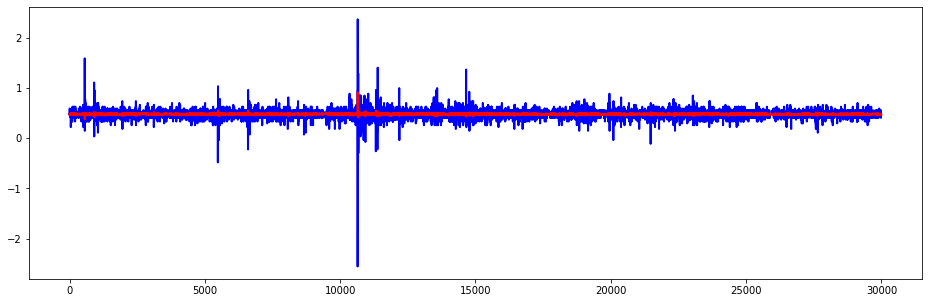

In [44]:
plt.figure(figsize=(16,5))
plt.plot(y_test_df, marker='', color='blue', linewidth=2)
plt.plot(y_pred_df, marker='', color='red', linewidth=2)

#### Построение гистограммы распределения ошибок

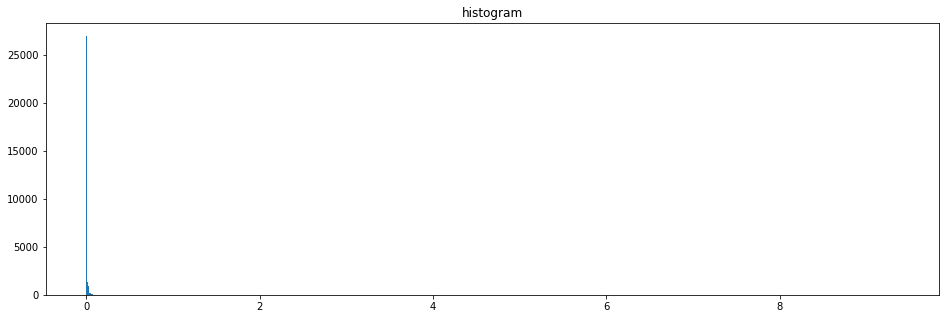

In [45]:
plt.figure(figsize=(16,5))
plt.hist(np.square(y_test - y_pred), bins=1000) 
plt.title("histogram") 
plt.show()

## Реккурентная нейронная сеть (для target)

#### Cуммарный объем заявок в стакане

In [46]:
tr_total_orders = (np.sum(df['ask_amount'].to_list(), axis=1) + np.sum(df['bid_amount'].to_list(), axis=1))
te_total_orders = (np.sum(test['ask_amount'].to_list(), axis=1) + np.sum(test['bid_amount'].to_list(), axis=1))

#### Дисбаланс объемов всех заявок на продажу и всех заявок на покупку (разность между суммарным объемом заявок на продажу и суммарным обьемом заявок на покупку)

In [47]:
tr_imbalance = (np.sum(df['ask_amount'].to_list(), axis=1) - np.sum(df['bid_amount'].to_list(), axis=1))
te_imbalance = (np.sum(test['ask_amount'].to_list(), axis=1) - np.sum(test['bid_amount'].to_list(), axis=1))

#### Разница между лучшей ценой на продажу и лучшей ценой на покупку

In [48]:
tr_min_diff = (np.min(df['ask_rate'].to_list(), axis=1) - np.max(df['bid_rate'].to_list(), axis=1))
te_min_diff = (np.min(test['ask_rate'].to_list(), axis=1) - np.max(test['bid_rate'].to_list(), axis=1))

#### Средняя цена

In [49]:
tr_mid_price = (df['midprice'].to_numpy())
te_mid_price = (test['midprice'].to_numpy())

#### Объединение предыдущих признаков в единую матрицу признаков

In [50]:
X_train = np.vstack([tr_total_orders, tr_imbalance, tr_min_diff, tr_mid_price]).transpose()
X_test = np.vstack([te_total_orders, te_imbalance, te_min_diff, te_mid_price]).transpose()

X_train_mean = X_train.mean(axis=0)
X_train_std = X_train.std(axis=0)
X_train = (X_train - X_train_mean) / X_train_std
X_test = (X_test - X_train_mean) / X_train_std


y_train = (df['target']).to_numpy()
y_test = (test['target']).to_numpy()

y_train_mean = y_train.mean(axis=0)
y_train_std = y_train.std(axis=0)
y_train = (y_train - y_train_mean) / y_train_std
y_test = (y_test - y_train_mean) / y_train_std

In [51]:
def multivariate_data(dataset, target, history_size, target_size):
    data = []
    labels = []

    start_index = history_size
    end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, 1)
        data.append(dataset[indices])
        labels.append(target[i+target_size])

    return np.array(data), np.array(labels)

#### Формирование обучающей выборки для реккурентной нейронной сети с историей из 16 тиков. Предсказываем событие через 4 тика.

In [52]:
past_history = 16
future_target = 4

x_train_single, y_train_single = multivariate_data(X_train, y_train,
                                                   past_history,
                                                   future_target)

x_test_single, y_test_single = multivariate_data(X_test, y_test,
                                                 past_history,
                                                 future_target)

In [53]:
BATCH_SIZE = 256
BUFFER_SIZE = 200

train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_data_single = tf.data.Dataset.from_tensor_slices((x_test_single, y_test_single))
test_data_single = test_data_single.batch(BATCH_SIZE).repeat()

In [54]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mse')

In [55]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=test_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 1.1218 - val_loss: 1.7987
Epoch 2/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9007 - val_loss: 1.8133
Epoch 3/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0723 - val_loss: 1.8126
Epoch 4/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9350 - val_loss: 1.8200
Epoch 5/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0739 - val_loss: 1.8047
Epoch 6/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9653 - val_loss: 1.8399
Epoch 7/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9333 - val_loss: 1.8202
Epoch 8/10
200/200 [==============================] - 1s 5ms/step - loss: 1.1258 - val_loss: 1.8012
Epoch 9/10
200/200 [==============================] - 1s 5ms/step - loss: 0.9079 - val_loss: 1.8179
Epoch 10/10
200/200 [==============================] - 1s 5ms/step - loss: 1.0559 - val_loss: 1.8128

In [56]:
def create_time_steps(length):
    return list(range(-length, 0))

def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt


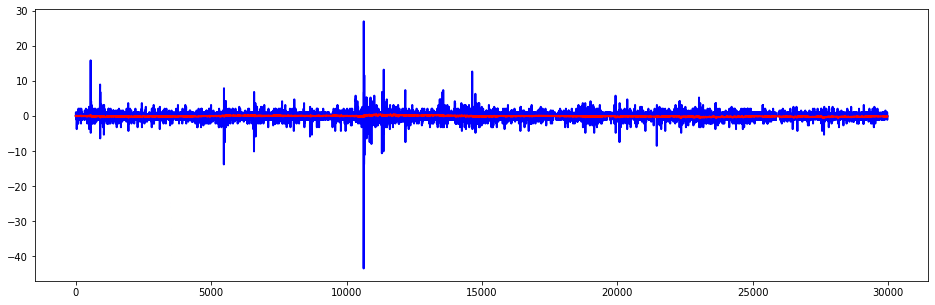

In [57]:
y_pred = single_step_model.predict(x_test_single).flatten()

y_pred_df = pd.DataFrame(data=y_pred)
y_test_df = pd.DataFrame(data=y_test_single)

plt.figure(figsize=(16,5))
plt.plot(y_test_df, marker='', color='blue', linewidth=2)
plt.plot(y_pred_df, marker='', color='red', linewidth=2)